# Test Ben's notebook

In [1]:
import numpy                as np
import xarray               as xr
import datetime             as dtm
import dateutil.parser      as dparser
import matplotlib.pyplot    as plt
import matplotlib.animation as animation
import os
import collections

from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Rectangle

In [2]:
def load_NEMO(
    timerange, depth, w_grid, spacing,
    ERDDAP_url='https://salishsea.eos.ubc.ca/erddap/griddap'
):
    """Loads and processes Salish Sea NEMO 3.4 salinity and velocity fields
    on the specified timerange, depth, domain window, and vector spacing.
    """
    
    # Slice objects for xarray indexing
    tslice = slice(timerange[0], timerange[1])
    xslice = slice(w_grid[0], w_grid[1])
    yslice = slice(w_grid[2], w_grid[3])
    
    # Load Salish Sea NEMO results from ERDDAP server as xarray DataSets
    NEMO_grid = xr.open_dataset(os.path.join(ERDDAP_url, 'ubcSSnBathymetry2V1'))
    NEMO_trc  = xr.open_dataset(os.path.join(ERDDAP_url, 'ubcSSn3DTracerFields1hV1'))
    NEMO_u    = xr.open_dataset(os.path.join(ERDDAP_url, 'ubcSSn3DuVelocity1hV1'))
    NEMO_v    = xr.open_dataset(os.path.join(ERDDAP_url, 'ubcSSn3DvVelocity1hV1'))
    
    # Extract results as xarray DataArrays
    lon      = NEMO_grid.longitude.sel(gridX=xslice, gridY=yslice)
    lat      = NEMO_grid.latitude.sel( gridX=xslice, gridY=yslice)
    salinity = NEMO_trc.salinity.sel(  gridX=xslice, gridY=yslice, time=tslice).sel(
                                       depth=depth, method='nearest')
    u        = NEMO_u.uVelocity.sel(   gridX=xslice, gridY=yslice, time=tslice).sel(
                                       depth=depth, method='nearest')
    v        = NEMO_v.vVelocity.sel(   gridX=xslice, gridY=yslice, time=tslice).sel(
                                       depth=depth, method='nearest')
    
    # Unstagger currents
    u = np.add(u[..., :-1   ], u[..., 1:   ]) / 2
    v = np.add(v[..., :-1, :], v[..., 1:, :]) / 2
    v = v.reindex_like(u)
    
    # Subsample currents
    u = u[:, ::spacing, ::spacing]
    v = v[:, ::spacing, ::spacing]
        
    # Rotate currents
    theta_rad = 29 * np.pi / 180
    u_map = u * np.cos(theta_rad) - v * np.sin(theta_rad)
    v_map = u * np.sin(theta_rad) + v * np.cos(theta_rad)
    
    # Return as dict
    NEMO = {'lon': lon, 'lat': lat, 'salinity': salinity, 'u': u_map, 'v': v_map}
    
    return NEMO

In [3]:
def make_figure(ax, cmap, time_ind, w_map, spacing, NEMO):
    """Plots horizontal Salish Sea NEMO salinity and velocity fields
    on a basemap instance at the specified time index, map window, and
    vector spacing. (Vector spacing must be the SAME as that used in
    load_NEMO!)
    """
    
    # Find center coords
    lon_0 = (w_map[1] - w_map[0]) / 2 + w_map[0]
    lat_0 = (w_map[3] - w_map[2]) / 2 + w_map[2]
    
    # Plot map
    m = Basemap(projection='lcc', resolution='h', lon_0=lon_0, lat_0=lat_0,
                llcrnrlon=w_map[0], urcrnrlon=w_map[1],
                llcrnrlat=w_map[2], urcrnrlat=w_map[3])
    m.drawcoastlines(zorder=1)
    m.fillcontinents(color='burlywood', lake_color='white')
    m.drawmeridians(np.arange(w_map[0], w_map[1], 0.5), labels=[0, 0, 0, 1])
    m.drawparallels(np.arange(w_map[2], w_map[3], 0.5), labels=[1, 0, 0, 0])
    
    # Get map coordinates
    NEMO['x_map'], NEMO['y_map'] = m(NEMO['lon'].values, NEMO['lat'].values)
    
    # Plot salinity
    CONT_OBJ = m.contourf(NEMO['x_map'], NEMO['y_map'],
                np.ma.masked_values(NEMO['salinity'].sel(time=time_ind, method='nearest'), 0),
                range(32), cmap=cmap, zorder=0)
    cbar = m.colorbar(CONT_OBJ)
    cbar.set_label('Practical Salinity')
    
    # Plot currents
    QUIV_OBJ = m.quiver(
                NEMO['x_map'][1::spacing, 1::spacing], NEMO['y_map'][1::spacing, 1::spacing],
                np.ma.masked_values(NEMO['u'].sel(time=time_ind, method='nearest'), 0),
                np.ma.masked_values(NEMO['v'].sel(time=time_ind, method='nearest'), 0),
                scale=10)
    ax.add_patch(Rectangle((0.78, 0.9), 0.22, 0.1,
                facecolor='white', transform=ax.transAxes, zorder=4))
    Qkey = plt.quiverkey(QUIV_OBJ, 0.87, 0.93, 1, '1 m/s', coordinates='axes')
    Qkey.set_zorder(5)

    # Timestamp
    TEXT_OBJ = plt.text(0.02, 1.02, time_ind.strftime('%a %Y-%m-%d %H:%M:%S %Z'),
               transform=ax.transAxes, zorder=5)
    
    # Return as dict
    PLOT_OBJS = {'CONT_OBJ': CONT_OBJ, 'QUIV_OBJ': QUIV_OBJ, 'TEXT_OBJ': TEXT_OBJ}
    
    return NEMO, PLOT_OBJS

In [4]:
def update_figure(ax, cmap, time_ind, NEMO, PLOT_OBJS):
    """Updates horizontal Salish Sea NEMO salinity and velocity fields
    to the specified time index.
    """
    
    # Update NEMO salinity contours
    for C in PLOT_OBJS['CONT_OBJ'].collections: C.remove()
    PLOT_OBJS['CONT_OBJ'] = ax.contourf(
            NEMO['x_map'], NEMO['y_map'],
            np.ma.masked_values(NEMO['salinity'].sel(time=time_ind, method='nearest'), 0),
            range(32), cmap=cmap, zorder=0)
    
    # Update NEMO current vectors
    PLOT_OBJS['QUIV_OBJ'].set_UVC(
            np.ma.masked_values(NEMO['u'].sel(time=time_ind, method='nearest'), 0),
            np.ma.masked_values(NEMO['v'].sel(time=time_ind, method='nearest'), 0))
    
    # Update timestamp
    PLOT_OBJS['TEXT_OBJ'].set_text(time_ind.strftime('%a %Y-%m-%d %H:%M:%S %Z'))
    
    return PLOT_OBJS

In [5]:
def make_animation(
    timerange, depth=0, spacing=5, writepath='~/Desktop',
    w_grid=[100, 398, 230, 570], w_map=[-124, -122.7, 48.3, 49.7],
):
    """Animates Salish Sea NEMO 3.4 salinity and velocity fields over a
    Basemap instance on the specified timerange, depth, vector spacing,
    domain window, and map window. Saves to the the specified writepath.
    """
    
    # Parse dates
    starttime, endtime = map(dparser.parse, timerange)
    frames = (endtime - starttime).days * 24
    
    # Write file path
    writefile = 'NEMO_{}m_{}to{}.mp4'.format(
                depth, starttime.strftime('%Y%b%dT%H'), endtime.strftime('%Y%b%dT%H'))
    filepath = os.path.join(writepath, writefile)
    
    # Load NEMO
    NEMO = load_NEMO(timerange, depth, w_grid, spacing)
    
    # Make figure
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    cmap = plt.get_cmap('jet')
    cmap.set_bad('white')
    
    # Plot first timestep
    NEMO, PLOT_OBJS = make_figure(ax, cmap, starttime, w_map, spacing, NEMO)
    
    # Next frame definition
    def next_frame(t, PLOT_OBJS):
        time_ind = (starttime + dtm.timedelta(hours=t))
        PLOT_OBJS = update_figure(ax, cmap, time_ind, NEMO, PLOT_OBJS)
        return PLOT_OBJS
    
    # Animate
    mywriter = animation.FFMpegWriter(fps=12, bitrate=10000)
    ANI = animation.FuncAnimation(fig, next_frame, frames=frames, fargs=[PLOT_OBJS], blit=False)
    ANI.save(filepath, writer=mywriter)

In [6]:
timerange = ['2016 Jun 1 00:00', '2016 Jun 2 00:00']
writepath='/ocean/bmoorema/research/programming/swc/30Jun2016'
make_animation(timerange, writepath=writepath)

BrokenPipeError: [Errno 32] Broken pipe

# Mine

* Traditional way

In [7]:
from salishsea_tools import (nc_tools,viz_tools)
from matplotlib import animation
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
from glob import glob
import os
import datetime
import Animation as Amn
%matplotlib inline

In [8]:
## load model result file
run_date = datetime.datetime(2015,6,18)   
paths = '/results/SalishSea/nowcast/'
results_dir = os.path.join(paths, run_date.strftime('%d%b%y').lower())
grid_T = Amn.results_dataset('1h','grid_T',results_dir)

In [9]:
## set start time and end time
start_time = datetime.datetime(run_date.year, run_date.month, run_date.day, 0, 30)
end_time = datetime.datetime(run_date.year, run_date.month,run_date.day, 23,30)

In [10]:
def prepare_variables(t,z):
    latitude=grid_T.variables['nav_lat']  ## lat
    longitude=grid_T.variables['nav_lon'] ## lon
    S = grid_T.variables['vosaline']     ## salinity
    S =  np.ma.masked_values(S[t, z], 0)  ## mask zero value
    ssh = grid_T.variables['sossheig']  ## sea surface height
    timesteps = grid_T.variables['time_counter'] ## time_counter
    zlevels = grid_T.variables['deptht']  ## depths
    t_t = nc_tools.timestamp(grid_T, np.arange(timesteps.shape[0]))
    for ind in range(len(t_t)):
        t_t[ind] = t_t[ind].datetime
    tt = np.array(t_t) ## time in datetime
    ## store in dict
    Vars = {'lon': longitude, 'lat': latitude, 'salinity':S, 'ssh':ssh, 'time':tt, 'depth':zlevels}
    return Vars

In [11]:
def animate_salinity_ssh(t,z = 0,cmap = 'jet',cmin = 0,cmax = 30,delta = 4):
    """ make an animation of salinity contour 
       for nowcasts results in the specific
       region in the SoG as well as water level at PA"""

    ax1.clear()
    ax2.clear()
    
    numhours = (end_time - start_time).seconds //3600
    hours = [start_time + datetime.timedelta(hours=num) for num in range(0, numhours+1)]
    Vars = prepare_variables(t,z)
    
    viz_tools.set_aspect(ax2, coords = 'map', lats=Vars['lat'])
    cmap = plt.get_cmap(cmap)
    cmap.set_bad('burlywood')
    mesh = ax2.pcolormesh( Vars['lon'], Vars['lat'], Vars['salinity'], cmap=cmap)
    clines = ax2.contour(Vars['lon'][:],Vars['lat'][:], Vars['salinity'][:], np.arange(cmin, cmax, delta),colors='k')
    ax2.clabel(clines,  inline = 1, inline_spacing =-3, fmt='%1.1f')
   
    ##set title and x,y limit
    ax2.set_title(hours[t].strftime('%d-%b-%Y %H:%M')+ ' at depth {d:.2f}'.format(d = Vars['depth'][z]) +'m')
    ax2.set_xlim(-124.3, -122.5)
    ax2.set_ylim(48.8, 49.4)
    ax2.grid()
    
    ## for ax1
    ax1.plot(Vars['time'],Vars['ssh'][:,466,329],'-k')
    ax1.plot(Vars['time'][t],Vars['ssh'][t, 466, 329],'o',color='tomato',markersize=9)
    ax1.set_ylabel('Water level (m)')
    ax1.set_title('Modelled water level at Point Atkinson on ' + hours[t].strftime('%d-%b-%Y %H:%M'))
    return mesh,clines

AttributeError: 'QuadContourSet' object has no attribute 'set_animated'

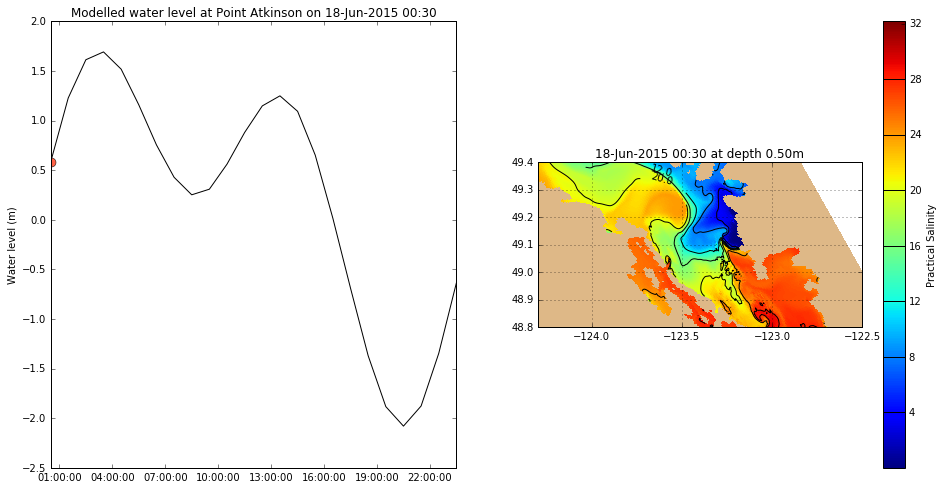

In [12]:
## Setting up first frame and static content
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16, 8))
mesh,clines = animate_salinity_ssh(23)

cbar = plt.colorbar(mesh, ax = ax2)
cbar.add_lines(clines)
cbar.set_label('Practical Salinity')
framess=np.arange(0,24)

#The animation function    
anim = animation.FuncAnimation(fig, animate_salinity_ssh, frames=framess, blit=True, repeat=False)
mywriter = animation.FFMpegWriter( fps=2, bitrate=10000)
#plt.show()
#anim.save('salinity-18jun15-0.5m-PA.mp4',writer=mywriter)

In [8]:
fig = plt.figure()
#x = np.arange(0, 2*np.pi, 0.01)
ssh = grid_T.variables['sossheig'][0:24,466,329]
timesteps = grid_T.variables['time_counter'] ## time_counter
zlevels = grid_T.variables['deptht']  ## depths
t_t = nc_tools.timestamp(grid_T, np.arange(timesteps.shape[0]))
for ind in range(len(t_t)):
    t_t[ind] = t_t[ind].datetime
tt = np.array(t_t) ## time in datetime
plt.plot(tt, ssh,'b')
#plt.axis([0,2*np.pi,-1,1])
plt.show()

* A couple of days

In [9]:
start_time = datetime.datetime(2015,8,1,0,30)
end_time = datetime.datetime(2015,8,26,23,30)

numdays = (end_time-start_time).days
dates =[start_time + datetime.timedelta(days=num)for num in range(0, numdays+1)]

In [10]:
for day in dates:
    results_dir = os.path.join(paths, day.strftime('%d%b%y').lower())
    grid_T = Amn.results_dataset('1h','grid_T',results_dir)
    S = grid_T.variables['vosaline']     ## salinity
    S =  np.ma.masked_values(S[t, z], 0)  ## mask zero value
    ssh = grid_T.variables['sossheig']  ## sea surface height